# Projet 6 – Introduction au MLOps : classification bancaire

Vous allez explorer les bases du MLOps en versionnant et suivant un modèle de classification binaire (octroi de crédit) grâce à des outils comme MLflow.

🔧 Objectifs :
- Suivi des performances d’un modèle
- Gestion des hyperparamètres
- Contrôle du surapprentissage

Data :
- Données issues [kaggle](https://www.kaggle.com/c/GiveMeSomeCredit/data)

In [4]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

FILE_INFO = "Data Dictionary"
FILE_TEST = "cs-test"
FILE_TRAINING = "cs-training"
FILE_SAMPLE_ENTRY = "sampleEntry"
DATA_INFO = pd.read_excel(f"../data/{FILE_INFO}.xls")
DATA_TEST = pd.read_csv(f"../data/{FILE_TEST}.csv", index_col=0)
DATA_TRAINING = pd.read_csv(f"../data/{FILE_TRAINING}.csv", index_col=0)
DATA = pd.concat([DATA_TRAINING, DATA_TEST], axis=0, ignore_index=True)
print(DATA.columns)
print(DATA.shape)
DATA.dropna(axis=0, how='any', inplace=True)
DATA.reset_index(drop=True, inplace=True)
DATA.head()

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')
(251503, 11)


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1.0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0.0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0.0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0.0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0.0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


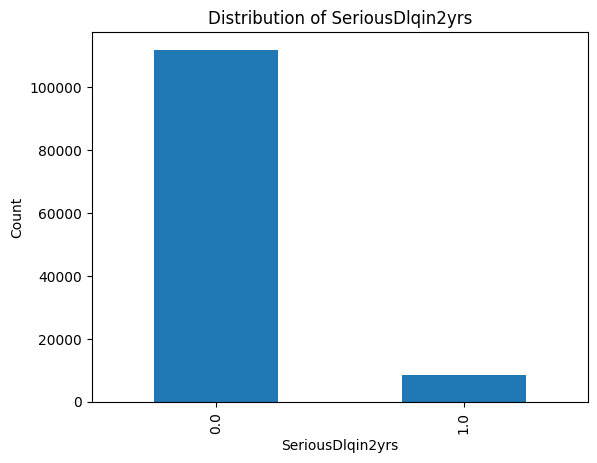

SeriousDlqin2yrs
0.0    8357
1.0    8357
Name: count, dtype: int64


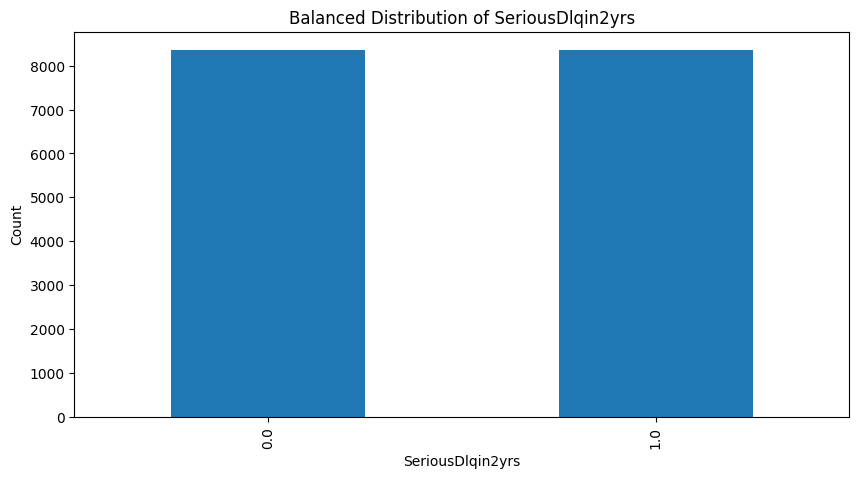

In [15]:
# équilibrage des classes
DATA['SeriousDlqin2yrs'].value_counts().plot(kind='bar')
plt.title('Distribution of SeriousDlqin2yrs')
plt.xlabel('SeriousDlqin2yrs')
plt.ylabel('Count')
plt.show()

# garder autant de 0 que de 1, il y a beaucoup plus de 0 que de 1
# on va donc réduire les 0 pour équilibrer
DATA_0 = DATA[DATA['SeriousDlqin2yrs'] == 0]
DATA_1 = DATA[DATA['SeriousDlqin2yrs'] == 1]
DATA_0_sample = DATA_0.sample(n=len(DATA_1), random_state=42)
DATA = pd.concat([DATA_0_sample, DATA_1], axis=0, ignore_index=True)
print(DATA['SeriousDlqin2yrs'].value_counts())
# réinitialiser les index
DATA.reset_index(drop=True, inplace=True)
plt.figure(figsize=(10, 5))
DATA['SeriousDlqin2yrs'].value_counts().plot(kind='bar')
plt.title('Balanced Distribution of SeriousDlqin2yrs')
plt.xlabel('SeriousDlqin2yrs')
plt.ylabel('Count')
plt.show()

Best Hyperparameters: {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'log2', 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}
Accuracy: 0.7544122046066407
Confusion Matrix:
 [[1351  320]
 [ 501 1171]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.81      0.77      1671
         1.0       0.79      0.70      0.74      1672

    accuracy                           0.75      3343
   macro avg       0.76      0.75      0.75      3343
weighted avg       0.76      0.75      0.75      3343



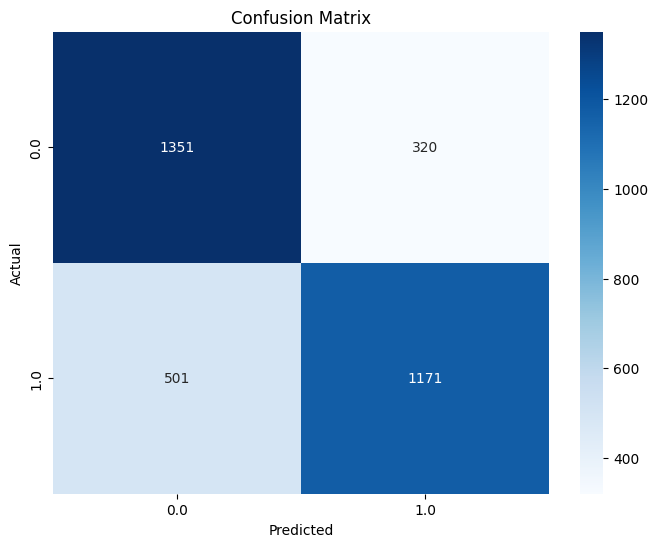

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X = DATA.drop(columns=['SeriousDlqin2yrs'])
y = DATA['SeriousDlqin2yrs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': [None, 'sqrt', 'log2'],
    'splitter': ['best', 'random'],
    'min_impurity_decrease': [0.0, 0.01, 0.1],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 2, 1: 1}],
    'ccp_alpha': [0.0, 0.01, 0.1]
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

model = DecisionTreeClassifier(**grid_search.best_params_)
model.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()